# ARGO study

This notebook demonstrates how we can use the concept of "data depth" to identify central and outlying points in the ARGO data.

In [38]:
import numpy as np
import cartopy.crs as ccrs
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from statsmodels.nonparametric.smoothers_lowess import lowess
import pandas as pd
from read import *

Subset the data for speed.

In [39]:
ii = np.random.choice(np.arange(temp.shape[1]), 5000, replace=False)
tempx = temp[:, ii]
psalx = psal[:, ii]
latx = lat[ii]
lonx = lon[ii]
dayx = day[ii]

Calculate the spatial depth of vector v relative to all columns of x.

In [40]:
def sdepth(v, x):
    p, n = x.shape
    z = x - v[:, None]
    zn = np.sqrt((z**2).sum(0))
    zn[np.abs(zn) < 1e-12] = np.inf
    z /= zn
    u = z.mean(1)
    return 1 - np.sqrt(np.sum(u**2))

Calculate the L2 depth of vector v relative to all columns of x.

In [41]:
def l2depth(v, x):
    p, n = x.shape
    z = x - v[:, None]
    zn = np.sqrt((z**2).sum(0))
    d = zn.mean()
    return 1e6 / (1 + d)

Estimate the band depth of vector v relative to all columns of x, using 500 random draws to estimate the band depth.

In [42]:
def bdepth(v, x, m=500):
    p, n = x.shape
    t = 0.0
    for k in range(m):
        ii = np.random.choice(n, 3, replace=False)
        z = x[:, ii]
        mn = z.min(1)
        mx = z.max(1)
        t += np.mean((v >= mn) & (v <= mx))
    t /= m
    return t

Calculate the depth of every column of x relative to the other columns, using 'dfun' as the depth function.

In [43]:
def depths(x, dfun, progress=False):
    p, n = x.shape
    d = np.zeros(n)
    for i in range(n):
        if progress and (i % 200 == 0):
            print(i, end="", flush=True)
            print(".", end="", flush=True)
        d[i] = dfun(x[:, i], x)
    if progress:
        print("done", flush=True)
    return d

Plot a small random selection of profiles from each depth decile.

In [44]:
def depth_cut(dp, x, q, pressure, ylab):
    dq = pd.qcut(dp, q)
    for (i,iv) in enumerate(dq.categories):
        ii = np.flatnonzero(dq == iv)
        jj = np.random.choice(ii, 10)

        plt.clf()
        plt.figure(figsize=(6.4,4.8))
        plt.grid(True)
        plt.title("Depth quantile %d %s" % (i + 1, str(iv)))
        for j in jj:
            plt.plot(pressure, x[:, j], "-", color="grey")
        plt.ylabel(ylab, size=15)
        plt.xlabel("Pressure", size=15)
        plt.show()

In [45]:
dp_temp = depths(tempx, sdepth, progress=True)
dp_psal = depths(psalx, sdepth, progress=True)

0.200.400.600.800.1000.1200.1400.1600.1800.2000.2200.2400.2600.2800.3000.3200.3400.3600.3800.4000.4200.4400.4600.4800.done
0.200.400.600.800.1000.1200.1400.1600.1800.2000.2200.2400.2600.2800.3000.3200.3400.3600.3800.4000.4200.4400.4600.4800.done


<Figure size 640x480 with 0 Axes>

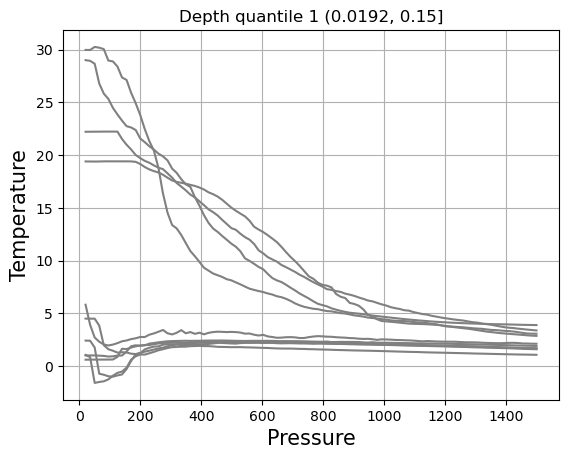

<Figure size 640x480 with 0 Axes>

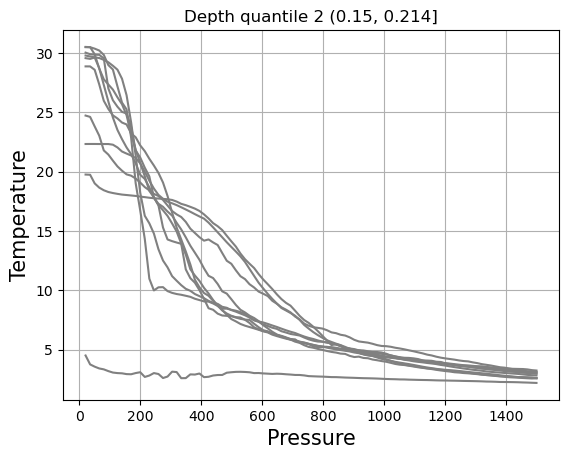

<Figure size 640x480 with 0 Axes>

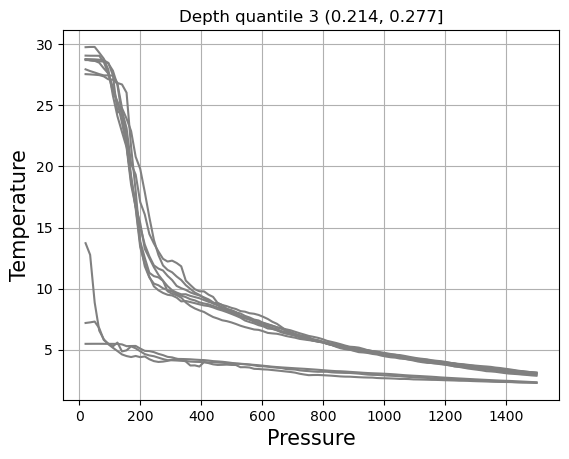

<Figure size 640x480 with 0 Axes>

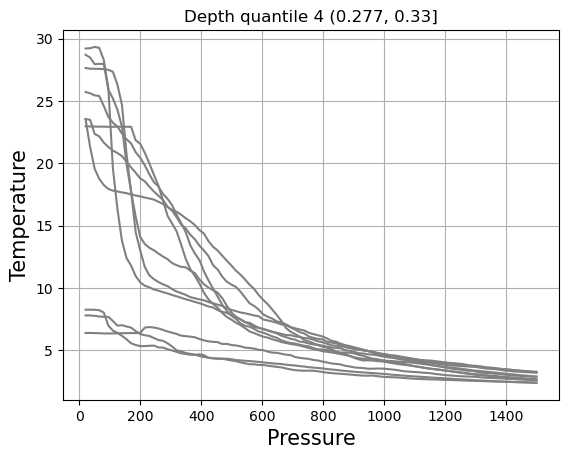

<Figure size 640x480 with 0 Axes>

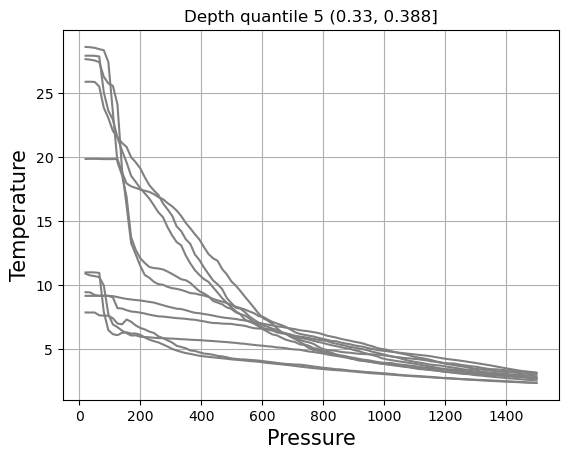

<Figure size 640x480 with 0 Axes>

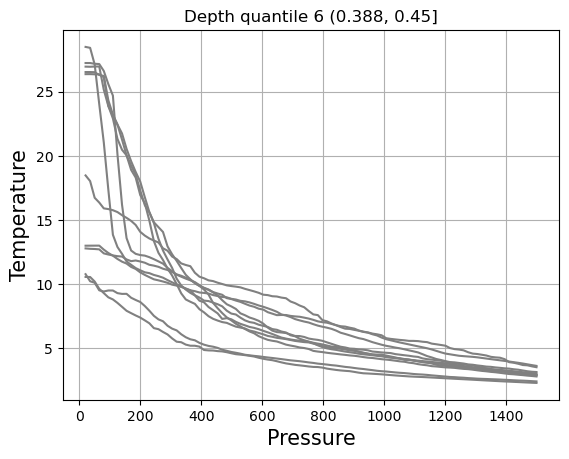

<Figure size 640x480 with 0 Axes>

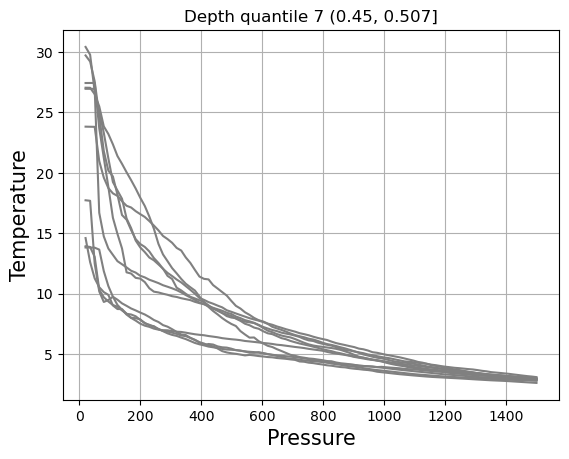

<Figure size 640x480 with 0 Axes>

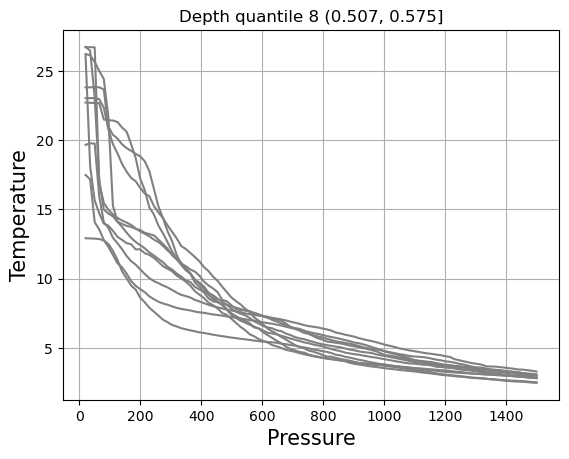

<Figure size 640x480 with 0 Axes>

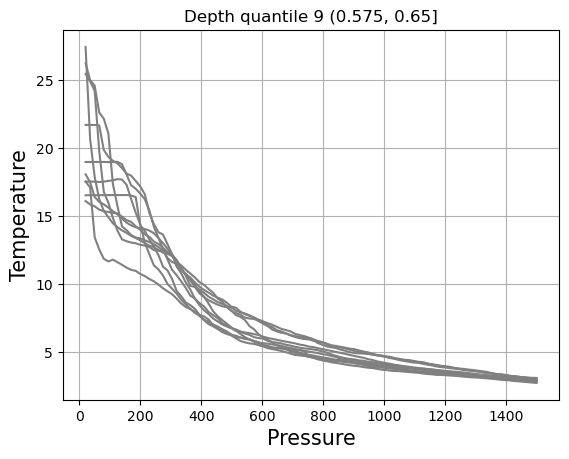

<Figure size 640x480 with 0 Axes>

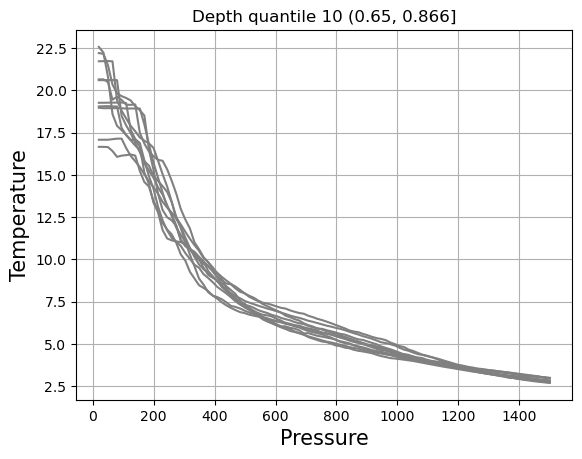

In [46]:
q = 10
depth_cut(dp_temp, tempx, q, pressure, "Temperature")

<Figure size 640x480 with 0 Axes>

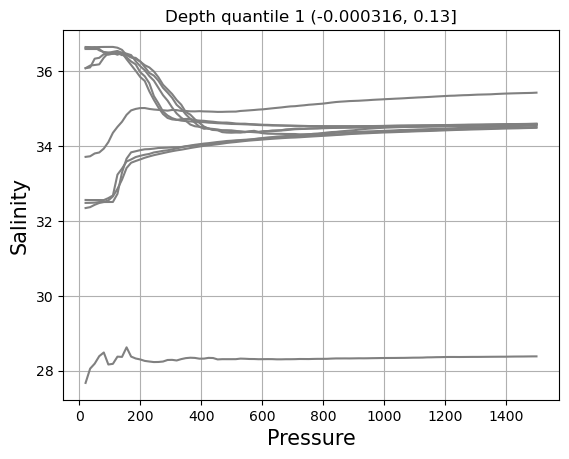

<Figure size 640x480 with 0 Axes>

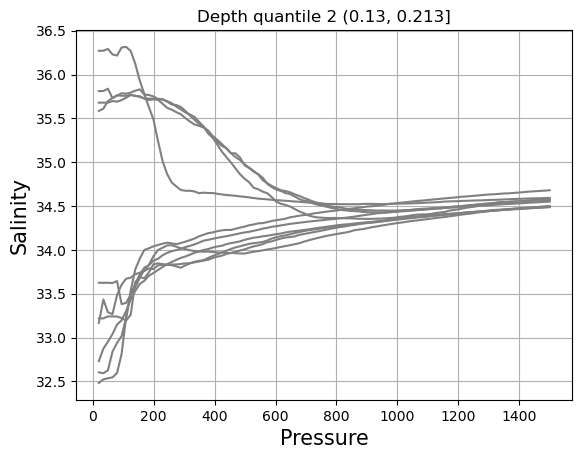

<Figure size 640x480 with 0 Axes>

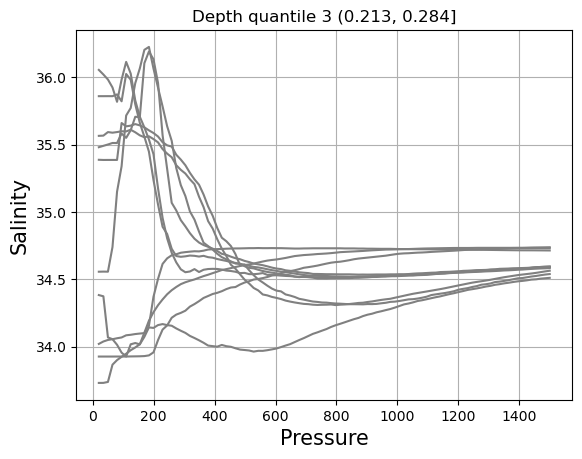

<Figure size 640x480 with 0 Axes>

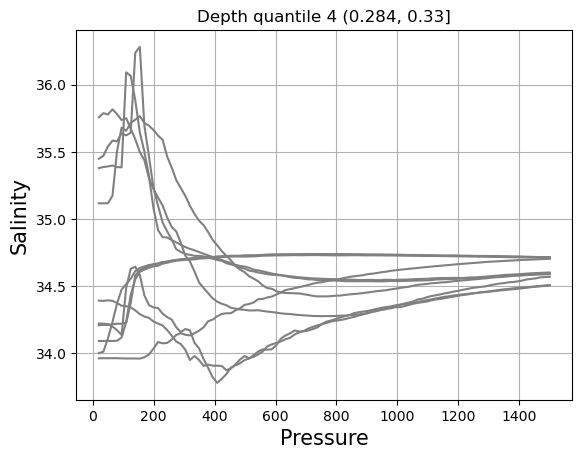

<Figure size 640x480 with 0 Axes>

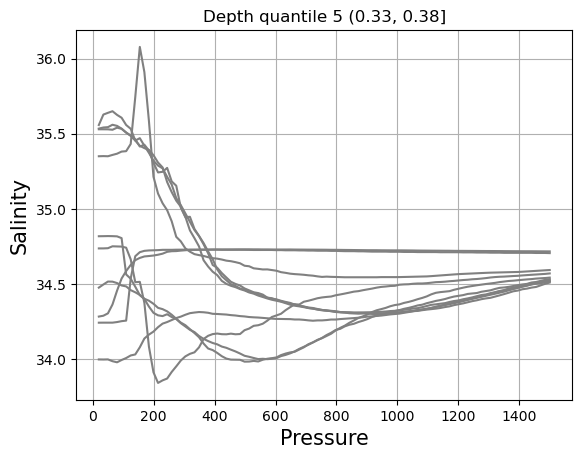

<Figure size 640x480 with 0 Axes>

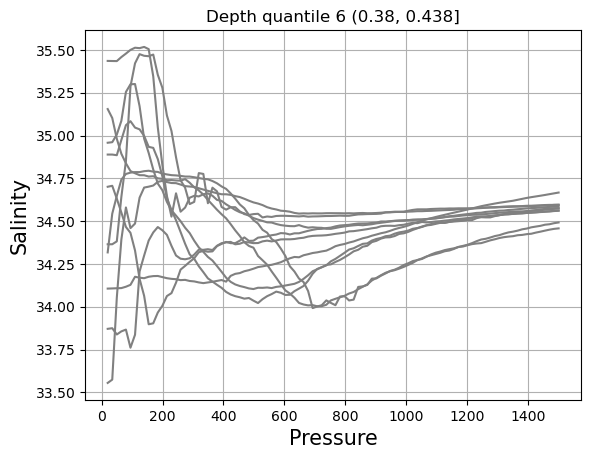

<Figure size 640x480 with 0 Axes>

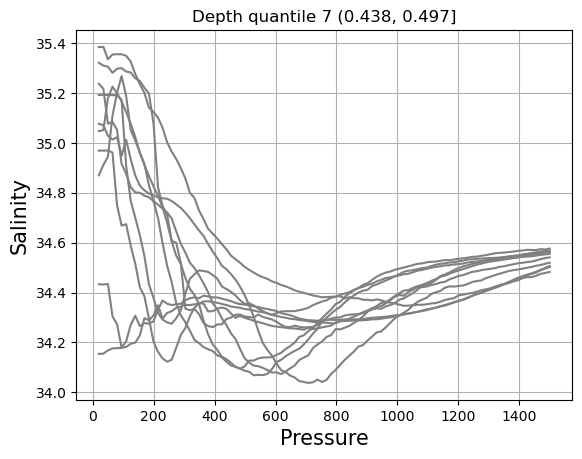

<Figure size 640x480 with 0 Axes>

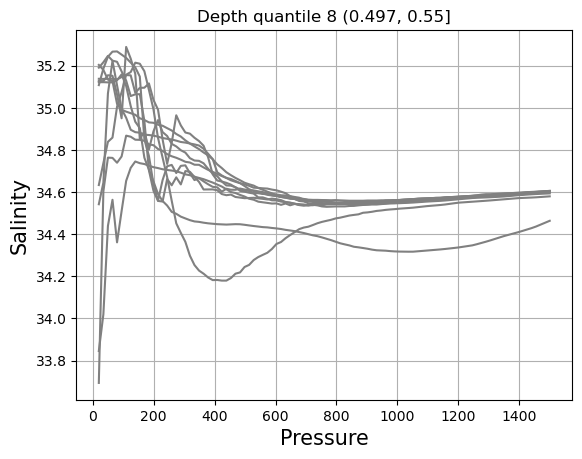

<Figure size 640x480 with 0 Axes>

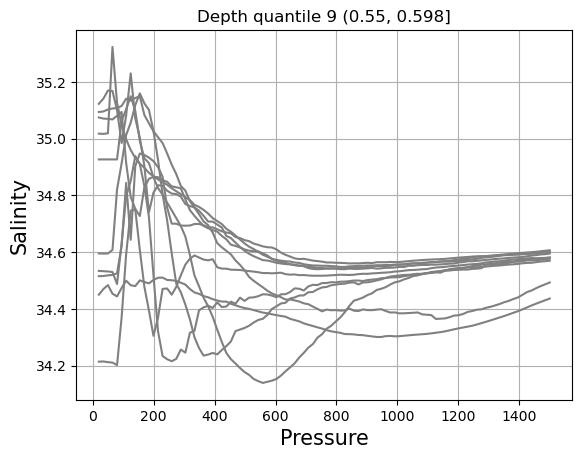

<Figure size 640x480 with 0 Axes>

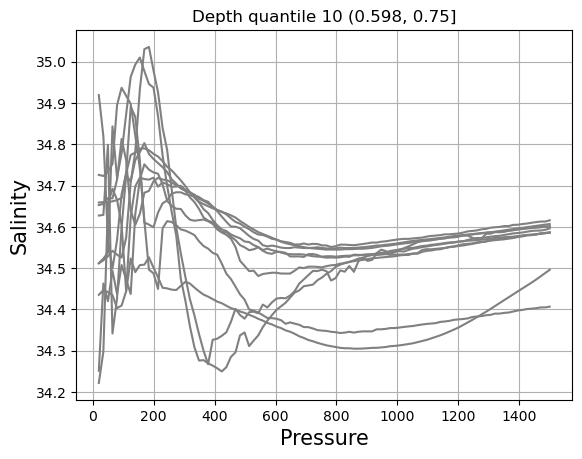

In [47]:
depth_cut(dp_psal, psalx, q, pressure, "Salinity")

Plot the estimated conditional mean depth relative to each explanatory variable. The bands in these plots are +/- f times the mean absolute deviation from the conditional mean.

In [48]:
def depth_correlates(dp, lat, lon, day, title, f=2):
    dpx = pd.DataFrame({"depth": dp, "lat": lat, "lon": lon, "day": day})
    vn = {"lat": "Latitude", "lon": "Longitude", "day": "Day"}
    for v in ["lat", "lon", "day"]:

        # A grid of 100 values covering the range of the
        # explanatory variable.
        xx = np.linspace(dpx[v].min(), dpx[v].max(), 100)

        # Use loess to regress depth on the explanatory variable
        m = lowess(dpx["depth"], dpx[v])
        dh = interp1d(m[:, 0], m[:, 1])(xx)

        # Use loess to regress the absolute depth residuals
        # on the explanatory variable
        aresid = np.abs(m[:, 1] - dpx["depth"])
        r = lowess(aresid, dpx[v])
        dq = interp1d(r[:, 0], r[:, 1])(xx)

        plt.clf()
        plt.title(title)
        plt.grid(True)
        plt.plot(xx, dh, "-")
        plt.fill_between(xx, dh-f*dq, dh+f*dq, color="grey", alpha=0.5)
        plt.xlabel(vn[v], size=15)
        plt.ylabel("Depth", size=15)
        plt.show()

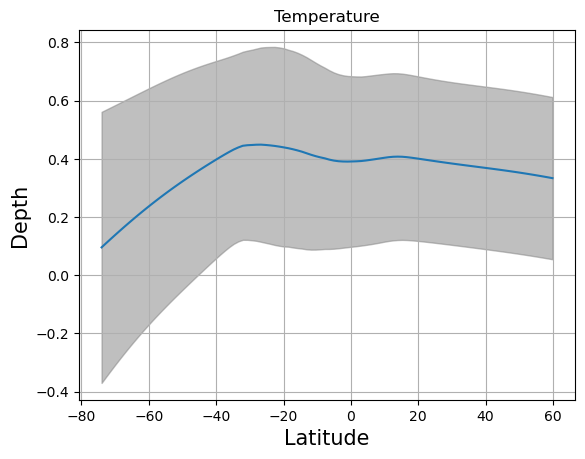

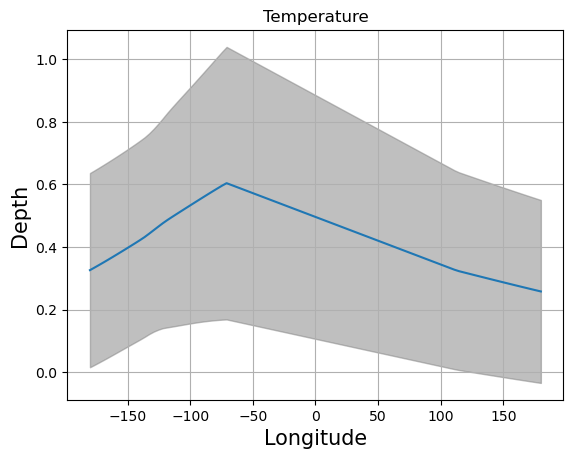

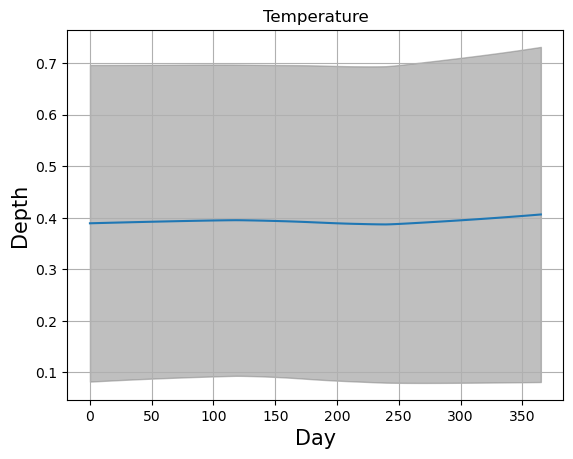

In [49]:
depth_correlates(dp_temp, latx, lonx, dayx, "Temperature")

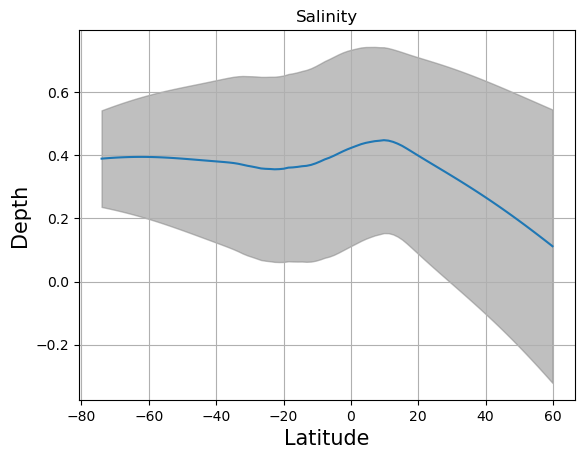

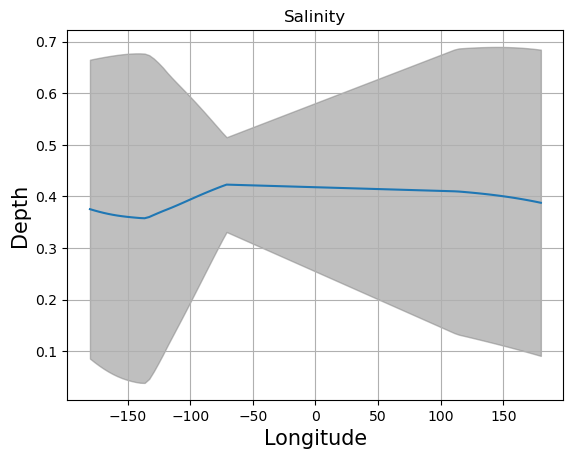

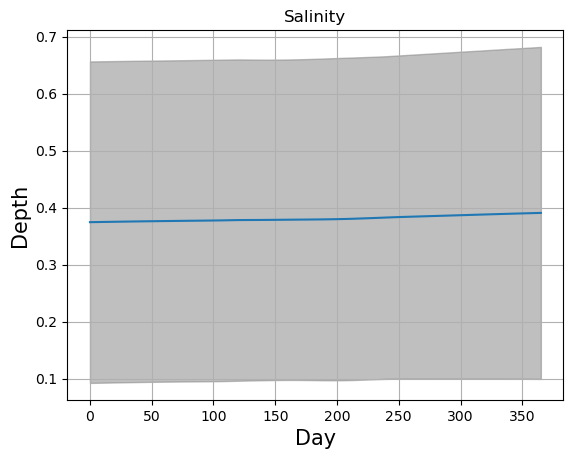

In [50]:
depth_correlates(dp_psal, latx, lonx, dayx, "Salinity")

Northern hemisphere

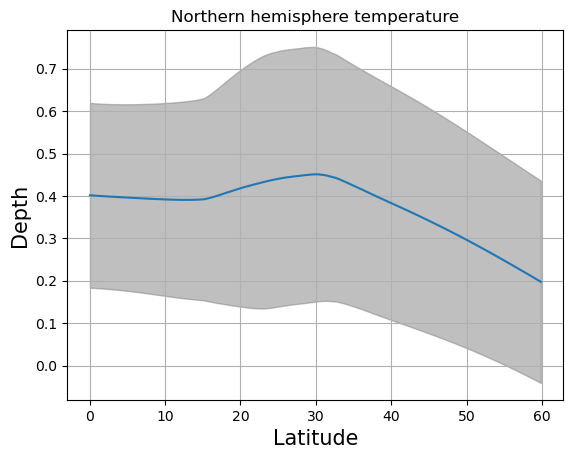

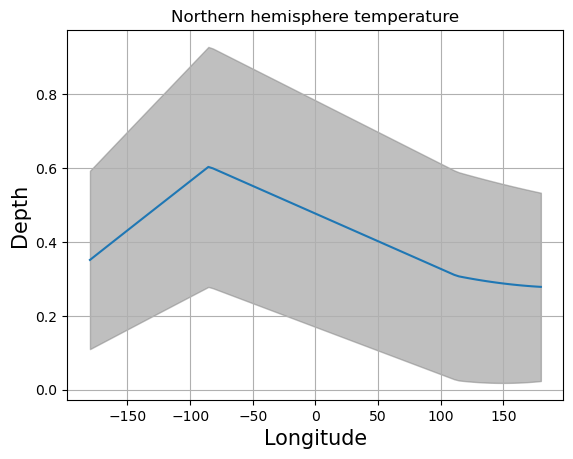

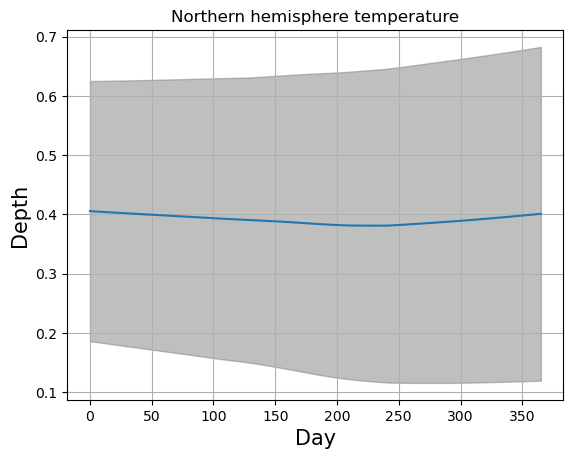

In [51]:
ii = np.flatnonzero(latx > 0)
depth_correlates(dp_temp[ii], latx[ii], lonx[ii], dayx[ii], "Northern hemisphere temperature")

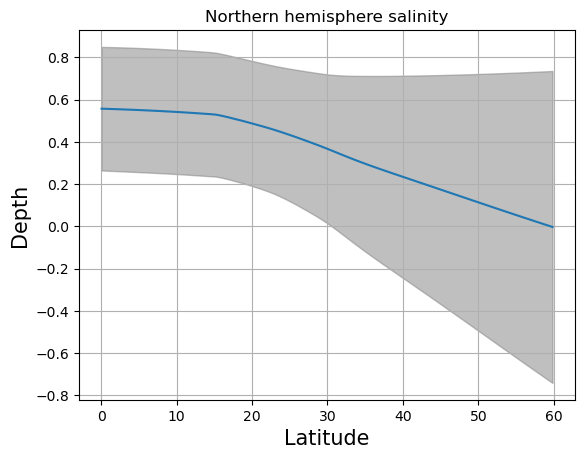

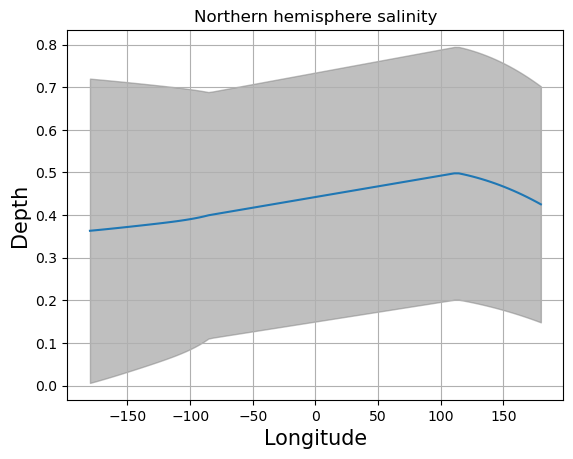

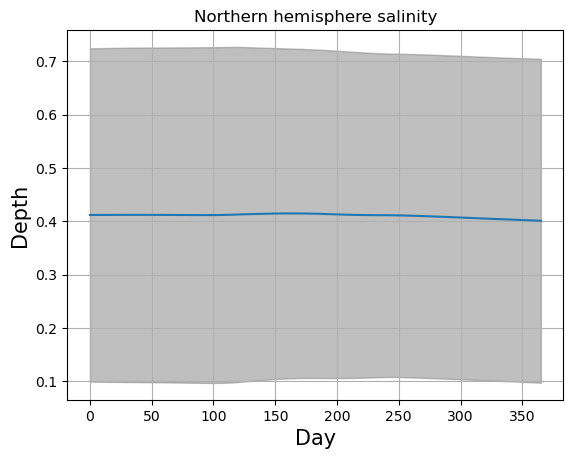

In [52]:
depth_correlates(dp_psal[ii], latx[ii], lonx[ii], dayx[ii], "Northern hemisphere salinity")

Southern hemisphere

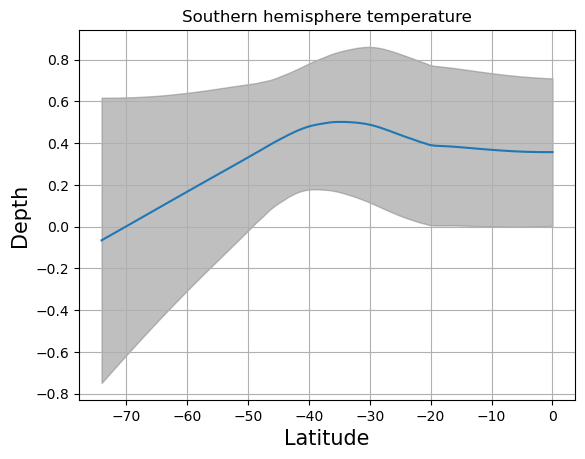

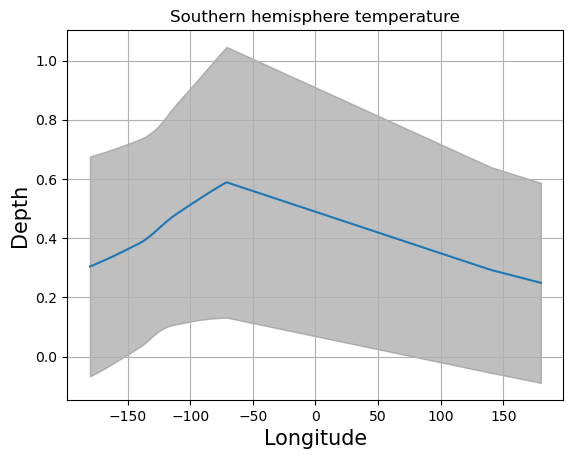

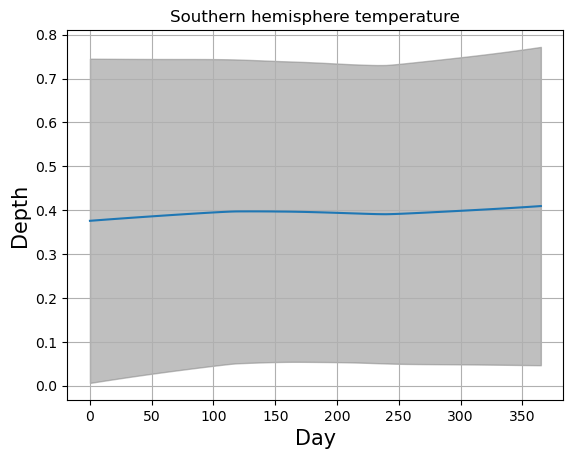

In [53]:
ii = np.flatnonzero(latx < 0)
depth_correlates(dp_temp[ii], latx[ii], lonx[ii], dayx[ii], "Southern hemisphere temperature")

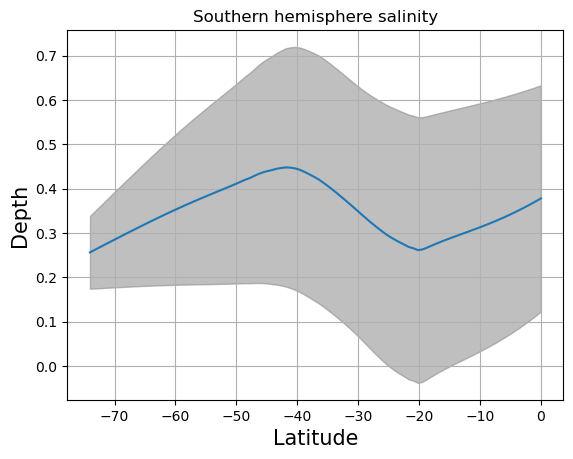

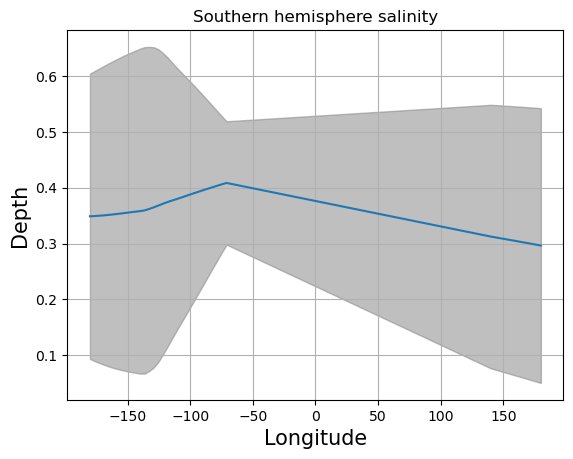

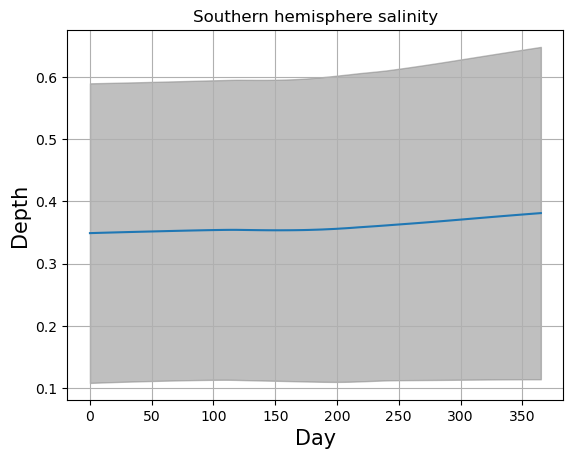

In [54]:
depth_correlates(dp_psal[ii], latx[ii], lonx[ii], dayx[ii], "Southern hemisphere salinity")

In [55]:
def plot_depth_map(dp, title):
    plt.clf()
    plt.figure(figsize=(8, 7.25))
    ax = plt.axes([0.05, 0.05, 0.84, 0.88], projection=ccrs.PlateCarree(central_longitude=180))
    ax.coastlines()
    ax.set_extent([115, 290, -70, 60])

    qq = np.argsort(np.argsort(dp)) / len(dp)
    ii = np.flatnonzero(qq < 0.1)
    plt.scatter(lonx[ii], latx[ii], s=8, color="red", label="shallow",
                transform=ccrs.Geodetic())
    ii = np.flatnonzero(qq > 0.9)
    plt.scatter(lonx[ii], latx[ii], s=8, color="blue", label="deep",
                transform=ccrs.Geodetic())

    ha,lb = plt.gca().get_legend_handles_labels()
    leg = plt.figlegend(ha, lb, loc="center right", handletextpad=0.01)
    leg.draw_frame(False)

    plt.title(title)
    plt.show()

<Figure size 640x480 with 0 Axes>

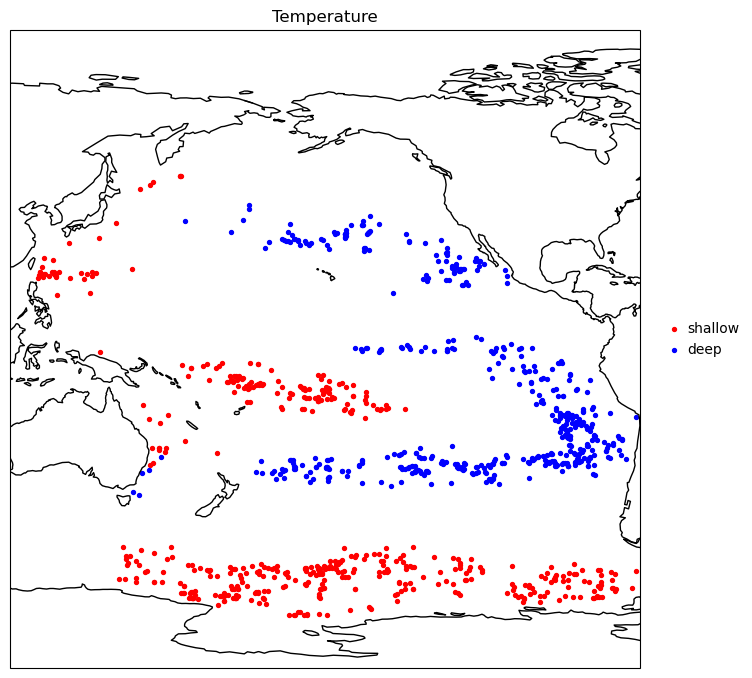

In [56]:
plot_depth_map(dp_temp, "Temperature")

<Figure size 640x480 with 0 Axes>

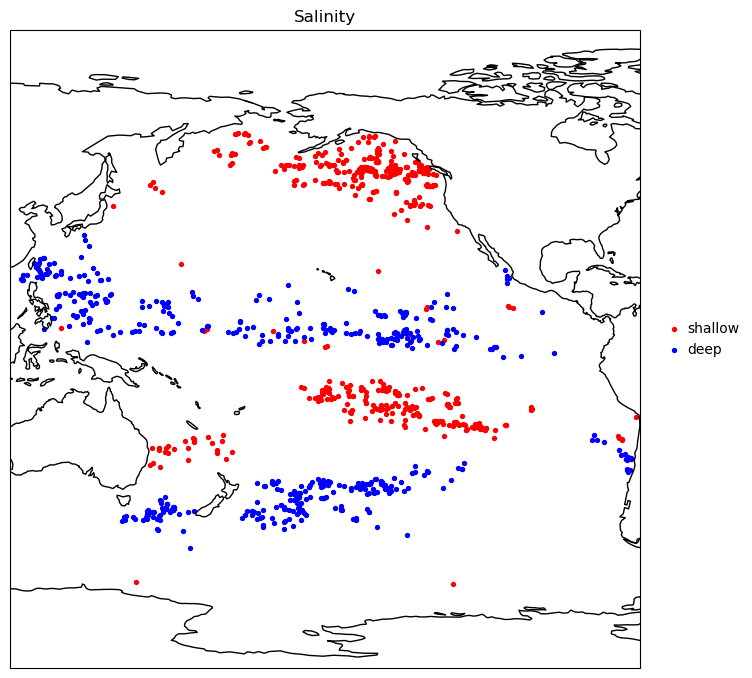

In [57]:
plot_depth_map(dp_psal, "Salinity")